### SSM For tibia and raadius periosteal and endosteal surfaces

Still has some issues:
- L / R images are not correctly landmarked
- Images have to be all the same size in z-dir (my dataset is already partially filtered for joint surfaces, need to adapt)
- Should be ran on the repro dataset, not on the validation one (which is smaller)

In [1]:
import pyssam
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import point_cloud_utils as pcu
from copy import copy
from skimage.measure import find_contours
from scipy.interpolate import interp1d

In [2]:
basepath = Path('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/01_DATA/TIBIA')
landmarkpath = Path('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/QMSKI/SSAM/') / 'landmarks_ext'
landmarkpath = Path('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/QMSKI/SSAM/') / 'landmarks_int'
# for all subdirs, get all '_CORTMASK' files
cort_list = []
trab_list = []
for file in basepath.iterdir():
    if file.is_file() and '_CORTMASK' in file.name and 'mhd' in file.suffix:
        cort_list.append(file)

In [3]:
def classify_and_store_contours(mask, slice_idx):
    contours = find_contours(mask[:, :, slice_idx])  # , level=0.5)
    if contours:
        outer_contours = contours[0]  # First contour as outer
        if len(contours) > 1:
            inner_contours = contours[1]  # Second contour as inner
    return outer_contours, inner_contours

def interpolate_contour(contour, num_points=100):
    distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)

    interp_func = interp1d(cumulative_distances, contour, axis=0, kind='linear')
    new_distances = np.linspace(0, cumulative_distances[-1], num_points)

    interpolated_contour = interp_func(new_distances)
    return interpolated_contour

def process_image(imnp):
    # get contour for each slice
    out_list = []
    inn_list = []
    for slice_idx in range(imnp.shape[2]):
        out, inn = classify_and_store_contours(imnp, slice_idx)
        # add slice_idx to array
        out = np.column_stack((out, np.ones(out.shape[0]) * slice_idx))
        inn = np.column_stack((inn, np.ones(inn.shape[0]) * slice_idx))

        # interpolate contours
        out = interpolate_contour(out, num_points=100)
        inn = interpolate_contour(inn, num_points=100)

        out_list.append(out)
        inn_list.append(inn)
    return out_list, inn_list

In [4]:
# Extract endosteal and periosteal surfaces
all_points_endo = []
all_points_peri = []
for file in cort_list:
    print(f'Extracting contours from {file.name}')
    sitk_image = sitk.ReadImage(str(file))
    np_image = sitk.GetArrayFromImage(sitk_image)
    np_image = np.transpose(np_image, (2, 1, 0))
    np_image = np.flip(np_image, axis=0)
    np_image = np_image[:, :, 5:450]
    out_list, inn_list = process_image(np_image)
    out_list = np.array(out_list).reshape(-1, 3)
    inn_list = np.array(inn_list).reshape(-1, 3)

    all_points_endo.append(inn_list)
    all_points_peri.append(out_list)
landmarks = np.array(all_points_endo)

Extracting contours from C0003096_CORTMASK.mhd
Extracting contours from C0003109_CORTMASK.mhd
Extracting contours from C0003098_CORTMASK.mhd
Extracting contours from C0003111_CORTMASK.mhd
Extracting contours from C0003095_CORTMASK.mhd
Extracting contours from C0003105_CORTMASK.mhd
Extracting contours from C0003106_CORTMASK.mhd
Extracting contours from C0003104_CORTMASK.mhd
Extracting contours from C0003108_CORTMASK.mhd
Extracting contours from C0003110_CORTMASK.mhd
Extracting contours from C0003101_CORTMASK.mhd
Extracting contours from C0003103_CORTMASK.mhd
Extracting contours from C0003115_CORTMASK.mhd
Extracting contours from C0003116_CORTMASK.mhd
Extracting contours from C0003112_CORTMASK.mhd
Extracting contours from C0003118_CORTMASK.mhd
Extracting contours from C0003114_CORTMASK.mhd
Extracting contours from C0003091_CORTMASK.mhd
Extracting contours from C0003097_CORTMASK.mhd
Extracting contours from C0003094_CORTMASK.mhd
Extracting contours from C0003099_CORTMASK.mhd
Extracting co

In [5]:
ssm_obj = pyssam.SSM(landmarks)
ssm_obj.create_pca_model(ssm_obj.landmarks_columns_scale)
mean_shape_columnvector = ssm_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)
shape_model_components = ssm_obj.pca_model_components

In [6]:
# Define some plotting functions
def plot_cumulative_variance(explained_variance, target_variance=-1):
    number_of_components = np.arange(0, len(explained_variance))+1
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def plot_shape_modes(
  mean_shape_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3)
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = ssm_obj.morph_model(
        mean_shape_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    ).reshape(-1, 3)

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape, 
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(3),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(3),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c="gray",
        s=1,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 2],
        c=offset_dist,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()

To obtain 90.0% variance, 5 modes are required


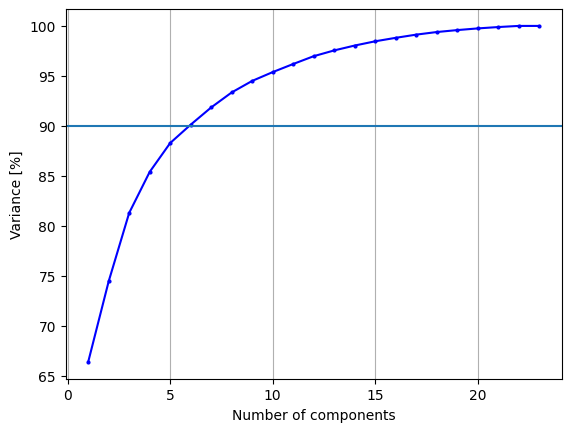

In [7]:
print(f"To obtain {ssm_obj.desired_variance*100}% variance, {ssm_obj.required_mode_number} modes are required")
plot_cumulative_variance(np.cumsum(ssm_obj.pca_object.explained_variance_ratio_), 0.9)

explained variance is 0.0807170243072318


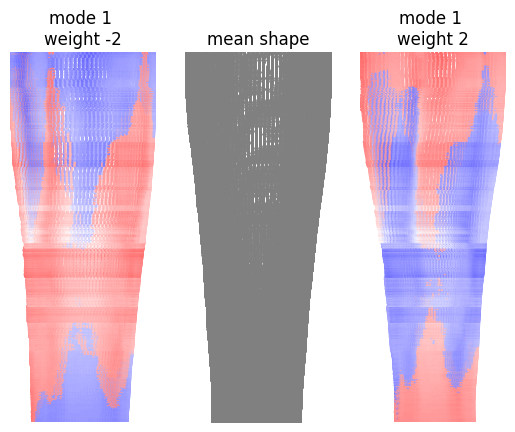

In [8]:
mode_to_plot = 1
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)

In [10]:
# convert mean shape to pyvista mesh
mean_shape_mesh = pv.PolyData(mean_shape)
mean_shape_mesh.plot(notebook=False)
# save mean shape to file
mean_shape_mesh.save('ssm.vtk')

In [42]:
import tetgen

# Read the VTK files
peri = pv.read('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/ssm_periosteum.vtk')
endo = pv.read('/home/simoneponcioni/Documents/01_PHD/03_Methods/HFE/ssm_endosteum.vtk')

# Process periosteum
surf_peri = peri.delaunay_3d()
tet_peri = tetgen.TetGen(surf_peri.extract_surface())
tet_peri.tetrahedralize(order=1, mindihedral=20)
grid_peri = tet_peri.grid.extract_surface()

# Process endosteum
surf_endo = endo.delaunay_3d()
tet_endo = tetgen.TetGen(surf_endo.extract_surface())
tet_endo.tetrahedralize(order=1, mindihedral=20)
grid_endo = tet_endo.grid.extract_surface()

# Perform boolean difference operation
cut = grid_peri.boolean_difference(grid_endo)

# Plotting
pl = pv.Plotter(notebook=False, shape=(1, 2))
pl.add_mesh(grid_peri, show_edges=True, opacity=0.5, color='grey')
pl.add_mesh(grid_endo, color="orange", show_edges=False, opacity=0.5)
pl.add_mesh(cut, color="red")
pl.subplot(0, 1)
pl.add_mesh(cut, color="red")
pl.link_views()
pl.show()

2024-08-08 16:08:04.463 (6896.178s) [    7F793BC4F740]      vtkDelaunay3D.cxx:513   WARN| vtkDelaunay3D (0x558336edc220): 2 degenerate triangles encountered, mesh quality suspect


In [58]:
import pyvista as pv
import tetgen
import numpy as np

# Load or create your PLC
sphere = pv.Sphere(theta_resolution=10, phi_resolution=10)

# Generate a background mesh with desired resolution
def generate_background_mesh(bounds, resolution=20, eps=1e-6):
    x_min, x_max, y_min, y_max, z_min, z_max = bounds
    grid_x, grid_y, grid_z = np.meshgrid(
        np.linspace(x_min - eps, x_max + eps, resolution),
        np.linspace(y_min - eps, y_max + eps, resolution),
        np.linspace(z_min - eps, z_max + eps, resolution),
        indexing="ij",
    )
    return pv.StructuredGrid(grid_x, grid_y, grid_z).triangulate()

bg_mesh = generate_background_mesh(sphere.bounds)

# Define sizing function based on radial distance from a focus point
def radial_sizing_function(points, focus_point=np.array([0, 0, 0]), max_size=1.0, min_size=0.1):
    distances = np.linalg.norm(points - focus_point, axis=1)
    # Invert the distances to make the center coarser and the outer thinner
    sizes = min_size + (max_size - min_size) * (1 - distances / np.max(distances))
    return np.clip(sizes, min_size, max_size)

# Apply the sizing function to the mesh
bg_mesh.point_data['target_size'] = radial_sizing_function(bg_mesh.points, focus_point=np.array([0, 1, 0]), max_size=2.0, min_size=0.01)

tet_kwargs = dict(order=1, mindihedral=20, minratio=1.5)
tet = tetgen.TetGen(sphere)
tet.tetrahedralize(bgmesh=bg_mesh, **tet_kwargs)
refined_mesh = tet.grid

# Plotting
pl = pv.Plotter(notebook=False, shape=(1, 2))
# clip sphere to show the interior in plane 0, 1, 0
sphere_clipped = sphere.clip(normal=[1,0,0], invert=True)
pl.add_mesh(sphere_clipped, show_edges=True, opacity=0.5, color='grey')
# pl.add_mesh(sphere, show_edges=True, opacity=1.0, color='grey')
pl.subplot(0, 1)
pl.add_mesh(refined_mesh, color="orange", show_edges=True, opacity=1)
pl.link_views()
pl.show()

In [74]:
# based on https://tetgen.pyvista.org/

import pyvista as pv
import tetgen
import numpy as np

pv.set_plot_theme('document')

# Load or create your PLC
sphere = pv.Sphere(theta_resolution=10, phi_resolution=10)

# Generate a background mesh with desired resolution
def generate_background_mesh(bounds, resolution=20, eps=1e-6):
    x_min, x_max, y_min, y_max, z_min, z_max = bounds
    grid_x, grid_y, grid_z = np.meshgrid(
        np.linspace(x_min - eps, x_max + eps, resolution),
        np.linspace(y_min - eps, y_max + eps, resolution),
        np.linspace(z_min - eps, z_max + eps, resolution),
        indexing="ij",
    )
    return pv.StructuredGrid(grid_x, grid_y, grid_z).triangulate()

bg_mesh = generate_background_mesh(sphere.bounds)

# Define sizing function based on radial distance from a focus point
def radial_sizing_function(points, focus_point=np.array([0, 0, 0]), max_size=1.0, min_size=0.1):
    distances = np.linalg.norm(points - focus_point, axis=1)
    # Scale the sizes to make the center finer and the outer coarser
    sizes = min_size + (max_size - min_size) * (distances / np.max(distances))
    return np.clip(sizes, min_size, max_size)

# Apply the sizing function to the mesh
bg_mesh.point_data['target_size'] = radial_sizing_function(bg_mesh.points, focus_point=np.array([0, 0, 0]), max_size=0.2, min_size=0.001)

# Tetrahedralize with background mesh
tet_kwargs = dict(order=1, mindihedral=20, minratio=1.5)
tet = tetgen.TetGen(sphere)
tet.tetrahedralize(bgmesh=bg_mesh, **tet_kwargs)
grid = tet.grid

# Get cell centroids
cells = grid.cells.reshape(-1, 5)[:, 1:]
cell_center = grid.points[cells].mean(1)

# Extract cells below the 0 xy plane
mask = cell_center[:, 2] < 0
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# Compute cell quality
cell_qual = subgrid.compute_cell_quality()['CellQuality']

# Plotting
pl = pv.Plotter(notebook=False, shape=(1, 2))
# Clip sphere to show the interior in plane 0, 1, 0
pl.add_mesh(sphere, show_edges=True, opacity=1.0, color='grey')
pl.subplot(0, 1)
pl.add_mesh(subgrid, scalars=cell_qual, stitle='Quality', cmap='bwr', clim=[0, 1], flip_scalars=True, show_edges=True)
pl.link_views()
pl.show()

/home/simoneponcioni/anaconda3/envs/hfe-accurate/lib/python3.9/site-packages/pyvista/plotting/_plotting.py:282: PyVistaDeprecationWarning: 
"stitle" is a deprecated keyword argument and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyVistaDeprecationWarning)
